/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/403
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5633 - loss: 2.6210 - val_accuracy: 0.5101 - val_loss: 2.4077
Epoch 2/403
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step - accuracy: 0.6068 - loss: 2.5213 - val_accuracy: 0.5810 - val_loss: 2.3654
Epoch 3/403
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - accuracy: 0.5988 - loss: 2.4625 - val_accuracy: 0.6255 - val_loss: 2.3180
Epoch 4/403
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step - accuracy: 0.6072 - loss: 2.4222 - val_accuracy: 0.6538 - val_loss: 2.2731
Epoch 5/403
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - accuracy: 0.6568 - loss: 2.3038 - val_accuracy: 0.6822 - val_loss: 2.2296
Epoch 6/403
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - accuracy: 0.6601 - loss: 2.3127 - val_accuracy: 0.7004 - val_loss: 2.1910
Epoch 7/403
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - accuracy: 0.6813 - loss: 2.2644 - val_accuracy: 0.7287 - val_loss: 2.1526
Epoch 8/403
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - accuracy: 0.6866 - loss: 2.2455 - val_accura

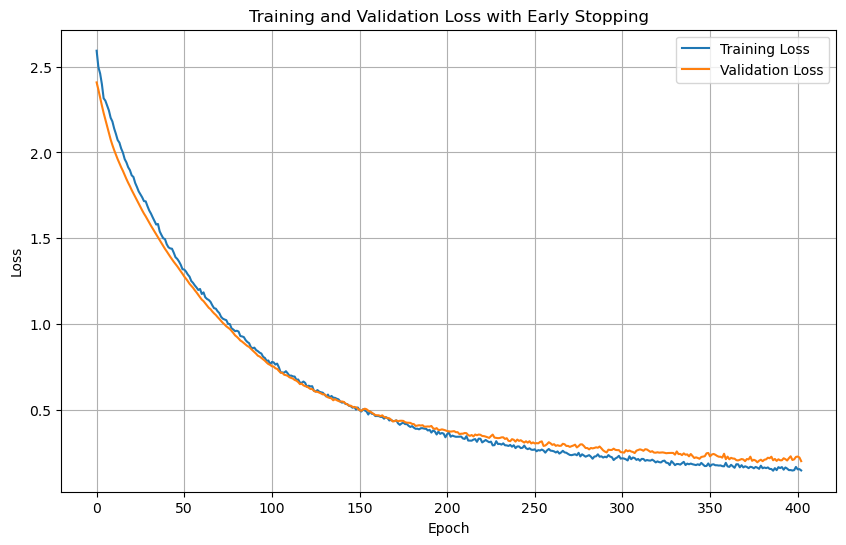

In [53]:
import numpy as np
import tensorflow as tf
import random
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from keras.regularizers import l2

# 시드 고정
def set_seeds(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)

# 시드 설정
set_seeds()

# 데이터 불러오기
df = pd.read_csv('/Users/jiminsim/Desktop/project/HR/전처리 데이터/IBM_2.csv')

# 파생 변수 추가
df['Long_Distance'] = df['DistanceFromHome'].apply(lambda x: 1 if x > 10 else 0)

# 독립 변수와 종속 변수 분리
X = df.drop('Attrition', axis=1)  # 종속 변수를 제외한 나머지 열이 독립 변수
y = df['Attrition']  # 종속 변수

# MinMaxScaler를 사용하여 모든 독립변수를 정규화
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# SMOTE를 사용하여 클래스 불균형 문제 해결
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# 학습용과 테스트용 데이터 분할 (8:2 비율)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# 신경망 모델 생성 및 구성 (L2 정규화 적용)
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.01)))  # L2 정규화 추가
model.add(BatchNormalization())
model.add(Dropout(0.3))  # 30% 드롭아웃 추가
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))  # L2 정규화 추가
model.add(BatchNormalization())
model.add(Dropout(0.3))  # 30% 드롭아웃 추가
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))  # L2 정규화 추가
model.add(BatchNormalization())
model.add(Dropout(0.3))  # 30% 드롭아웃 추가
model.add(Dense(1, activation='sigmoid'))

# Adam 옵티마이저 설정
adam = Adam(learning_rate=0.0001)

# 모델 컴파일
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

# 얼리스탑핑 설정: 검증 손실을 모니터링하고, 10번의 epoch 동안 개선되지 않으면 학습 중지
early_stopping = EarlyStopping(
    monitor='val_loss',  # 'val_accuracy'에서 'val_loss'로 변경
    patience=100,         # 개선되지 않는 epoch 수
    restore_best_weights=True  # 가장 좋은 성능을 보였던 가중치로 복원
)

# 모델 학습 시 history 객체로 반환하여 학습 과정을 기록
history = model.fit(
    X_train, y_train,
    epochs=403,  # 최대 epoch 수
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping], # 콜백으로 얼리스탑핑 추가
    verbose=1  # 출력 줄이기
)

# 평가
train_loss, train_accuracy = model.evaluate(X_train, y_train)
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Training Loss: {train_loss:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# 예측 결과 (훈련 및 테스트 데이터)
y_train_pred = (model.predict(X_train) > 0.5).astype(int)
y_test_pred = (model.predict(X_test) > 0.5).astype(int)

# 재현율 및 F1 스코어 계산
print("Training Classification Report:")
print(classification_report(y_train, y_train_pred))

print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred))

# 학습 및 검증 손실 시각화
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss with Early Stopping')
plt.legend()
plt.grid()
plt.show()


In [ ]:
# 모델 저장
model.save('/Users/jiminsim/Desktop/project/HR/IBM_model_1.keras')

In [45]:
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# 모델 파일 경로
model_path = '/Users/jiminsim/Desktop/project/HR/IBM_model_1.keras'

# 모델 로드
model = tf.keras.models.load_model(model_path)

# 데이터 로드
df = pd.read_csv('/Users/jiminsim/Desktop/project/HR/전처리 데이터/IBM_3.csv')

# 파생 변수 추가
df['Long_Distance'] = df['DistanceFromHome'].apply(lambda x: 1 if x > 10 else 0)

# 종속 변수와 독립 변수 분리
X = df.drop('Attrition', axis=1)
y = df['Attrition']

# 데이터 정규화
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# 학습 및 테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 평가
train_loss, train_accuracy = model.evaluate(X_train, y_train)
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Training Loss: {train_loss:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# 예측 결과 (훈련 및 테스트 데이터)
y_train_pred = (model.predict(X_train) > 0.5).astype(int)
y_test_pred = (model.predict(X_test) > 0.5).astype(int)

# 재현율 및 F1 스코어 계산
print("Training Classification Report:")
print(classification_report(y_train, y_train_pred))

print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred))


/opt/anaconda3/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 16 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - accuracy: 0.9934 - loss: 0.1463
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step - accuracy: 0.9934 - loss: 0.1501
Training Loss: 0.1374
Test Loss: 0.1727
Training Accuracy: 0.9949
Test Accuracy: 0.9864
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step
Training Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       978
           1       0.97      1.00      0.99       198

    accuracy                           0.99      1176
   macro avg       0.99      1.00      0.99      1176
weighted avg       1.00      0.99      0.99      1176


Test Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       255
           1       0.95      0.95      0.95        39

    accuracy                           0.99       294
   macro avg       0.97      0.97      0.97       294
weighted avg       0.